In [2]:

# pip install numpy pandas
import numpy as np

import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,Reshape,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import gc

In [4]:
raw_data_path1 ="D:/Master/Reseach/Dataset-for-Crop-Pest-and-Disease-Detection/Raw-Data/CCMT-Dataset"
crops_folder= os.listdir(raw_data_path1)
print(crops_folder)
tomatos_raw_data_path = os.path.join(raw_data_path1,"Tomato")
print(tomatos_raw_data_path)
tomatos_folder= os.listdir(tomatos_raw_data_path)
print(tomatos_folder)

['Cashew', 'Cassava', 'Maize', 'Tomato']
D:/Master/Reseach/Dataset-for-Crop-Pest-and-Disease-Detection/Raw-Data/CCMT-Dataset\Tomato
['healthy', 'leaf blight', 'leaf curl', 'septoria leaf spot', 'verticulium wilt']


Total images loaded: 5


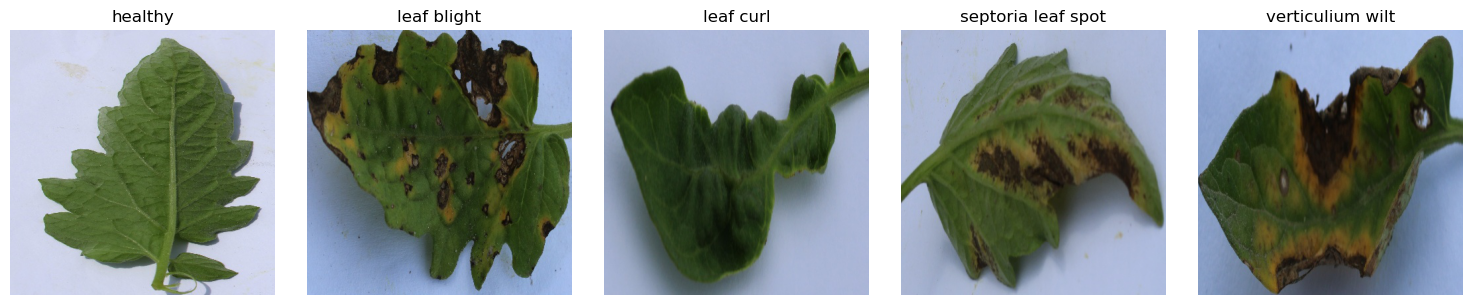

In [6]:
# Function to display images
# Function to display images from multiple folders
def show_images_from_folders(base_dir, tomatos_folders, num_images=10):
    images_to_display = []  # Store images and titles for display
    
    # Iterate over disease/pest category folders
    for subfolder in tomatos_folders:
        subfolder_path = os.path.join(base_dir, subfolder)

        # Ensure it's a directory
        if os.path.isdir(subfolder_path):
            # Get all image files in the subfolder
            images = [f for f in os.listdir(subfolder_path) if f.endswith('.jpg')]
                        
            # Display a few images from each subfolder
            for img_file in images[:num_images]: 
                img_path = os.path.join(subfolder_path, img_file)
                try:
                    img = Image.open(img_path)
                    images_to_display.append((img, f"{subfolder}"))  # Removed undefined 'crop' variable
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")

    # Calculate grid size dynamically
    total_images = len(images_to_display)
    print(f"Total images loaded: {total_images}")
    
    if total_images == 0:
        print("No images to display.")
        return

    cols = 5
    rows = -(-total_images // cols)  # Ceiling division for rows
    plt.figure(figsize=(15, rows * 3))                 
    
    # Plot images
    for i, (img, title) in enumerate(images_to_display):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(title)

    plt.tight_layout()
    plt.show()


# Call the function to display images
show_images_from_folders(tomatos_raw_data_path, tomatos_folder, num_images=1)

In [11]:
train_path ="D:/Master/Reseach/Dataset-for-Crop-Pest-and-Disease-Detection/CCMT Dataset-Augmented/Tomato/train_set/"
test_path = "D:/Master/Reseach/Dataset-for-Crop-Pest-and-Disease-Detection/CCMT Dataset-Augmented/Tomato/test_set/"

### InceptionsV3

In [17]:
# Load InceptionV3 without the top layer (to customize the output layer)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=[224,224,3])

In [21]:
# Freeze the base layers (InceptionV3) during initial training to only train the new top layers
for layer in base_model.layers:
    layer.trainable = False

In [23]:
from glob import glob
folder=glob("D:/Master/Reseach/Dataset-for-Crop-Pest-and-Disease-Detection/CCMT Dataset-Augmented/Tomato/train_set/*")
print(folder)

['D:/Master/Reseach/Dataset-for-Crop-Pest-and-Disease-Detection/CCMT Dataset-Augmented/Tomato/train_set\\healthy', 'D:/Master/Reseach/Dataset-for-Crop-Pest-and-Disease-Detection/CCMT Dataset-Augmented/Tomato/train_set\\leaf blight', 'D:/Master/Reseach/Dataset-for-Crop-Pest-and-Disease-Detection/CCMT Dataset-Augmented/Tomato/train_set\\leaf curl', 'D:/Master/Reseach/Dataset-for-Crop-Pest-and-Disease-Detection/CCMT Dataset-Augmented/Tomato/train_set\\septoria leaf spot', 'D:/Master/Reseach/Dataset-for-Crop-Pest-and-Disease-Detection/CCMT Dataset-Augmented/Tomato/train_set\\verticulium wilt']


In [25]:
x=Flatten()(base_model.output)
predict_inception=Dense(units=len(folder),activation="softmax")(x)
inception_model=Model(inputs=base_model.input,outputs=predict_inception)

### We have taken the optimizer Adam and the loss will be categorical crossentropy and our aim will be to find the accuracy

In [30]:
inception_model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [32]:
inception_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_94 (Conv2D)            │ (None, 111, 111, 32)      │             864 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_94        │ (None, 111, 111, 32)      │              96 │ conv2d_94[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_94 (Activation)    │ (None, 111, 111, 32)      │               0 │ batch_normalization_94[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_95 (Conv2D)            │ (None, 109, 109, 32)      │           9,216 │ activation_94[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_95        │ (None, 109, 109, 32)      │              96 │ conv2d_95[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_95 (Activation)    │ (None, 109, 109, 32)      │               0 │ batch_normalization_95[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_96 (Conv2D)            │ (None, 109, 109, 64)      │          18,432 │ activation_95[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_96        │ (None, 109, 109, 64)      │             192 │ conv2d_96[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_96 (Activation)    │ (None, 109, 109, 64)      │               0 │ batch_normalization_96[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_4               │ (None, 54, 54, 64)        │               0 │ activation_96[0][0]        │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_97 (Conv2D)            │ (None, 54, 54, 80)        │           5,120 │ max_pooling2d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_97        │ (None, 54, 54, 80)        │             240 │ conv2d_97[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_97 (Activation)    │ (None, 54, 54, 80)        │               0 │ batch_normalization_97[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_98 (Conv2D)            │ (None, 52, 52, 192)       │         138,24

 Total params: 22,058,789 (84.15 MB)

 Trainable params: 256,005 (1000.02 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [38]:
# Data augmentation and preprocessing for the training and validation sets
train_datagen=ImageDataGenerator(rescale=1./255,
                                 horizontal_flip=True,rotation_range=.2,shear_range=.2)
test_datagen=ImageDataGenerator(rescale=1./255)


# Create training and testing data generators
training_set=train_datagen.flow_from_directory(train_path, target_size=(224,224),class_mode="categorical",batch_size=32,shuffle=True)
test_set=test_datagen.flow_from_directory(test_path,target_size=(224,224),class_mode="categorical",batch_size=32,shuffle=True)


Found 10000 images belonging to 5 classes.
Found 2500 images belonging to 5 classes.


In [40]:

transfer_inception=inception_model.fit(
                                       training_set,
                                       validation_data=test_set,
                                       validation_steps=len(test_set),
                                       steps_per_epoch=len(training_set),
                                       epochs=20)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 350s 1s/step - accuracy: 0.8716 - loss: 1.0119 - val_accuracy: 0.7524 - val_loss: 4.8898
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 346s 1s/step - accuracy: 0.8909 - loss: 0.8414 - val_accuracy: 0.7676 - val_loss: 4.7654
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 340s 1s/step - accuracy: 0.8957 - loss: 0.8048 - val_accuracy: 0.7456 - val_loss: 4.4005
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 473s 2s/step - accuracy: 0.8897 - loss: 0.9660 - val_accuracy: 0.7260 - val_loss: 5.2654
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 499s 2s/step - accuracy: 0.8963 - loss: 0.7165 - val_accuracy: 0.7368 - val_loss: 5.3632
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 515s 2s/step - accuracy: 0.8908 - loss: 0.9544 - val_accuracy: 0.7740 - val_loss: 4.7290
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 584s 2s/step - accuracy: 0.9035 - loss: 0.8369 - val_accuracy: 0.7748 - val_loss: 4.3581
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 451s 1s/step - accuracy: 0.9108 - loss: 0.7134 - val_accu

In [42]:
# Scores is just a list containing loss and accuracy value
scores=inception_model.evaluate(training_set)   
scores2=inception_model.evaluate(test_set)
print("Test Loss is :"+str(scores2[0]))
print("Test Accuracy is :"+str(scores2[1]*100)+" %")
print("Training Loss is :"+str(scores[0]))
print("Training Accuracy is :"+str(scores[1]*100)+" %")


313/313 ━━━━━━━━━━━━━━━━━━━━ 282s 901ms/step - accuracy: 0.8970 - loss: 1.0055
79/79 ━━━━━━━━━━━━━━━━━━━━ 58s 733ms/step - accuracy: 0.7205 - loss: 8.2187
Test Loss is :7.855929851531982
Test Accuracy is :73.91999959945679 %
Training Loss is :0.9838082194328308
Training Accuracy is :89.64999914169312 %


In [48]:
inception_model.save("InceptionV3_Tomato1.h5")

In [50]:
test_steps_per_epoch = np.math.ceil(test_set.samples / test_set.batch_size)
# Generate predictions
predictions = inception_model.predict(test_set, steps=test_steps_per_epoch)

# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes and class Labels
true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys()) 

C:\Users\santo\AppData\Local\Temp\ipykernel_16912\1028900156.py:1: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  test_steps_per_epoch = np.math.ceil(test_set.samples / test_set.batch_size)


79/79 ━━━━━━━━━━━━━━━━━━━━ 62s 756ms/step


In [52]:
#Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

print("Classification Report:")
print(report)

Classification Report:
                    precision    recall  f1-score   support

           healthy       0.20      0.20      0.20       500
       leaf blight       0.21      0.14      0.16       500
         leaf curl       0.21      0.19      0.20       500
septoria leaf spot       0.18      0.10      0.13       500
  verticulium wilt       0.20      0.38      0.26       500

          accuracy                           0.20      2500
         macro avg       0.20      0.20      0.19      2500
      weighted avg       0.20      0.20      0.19      2500



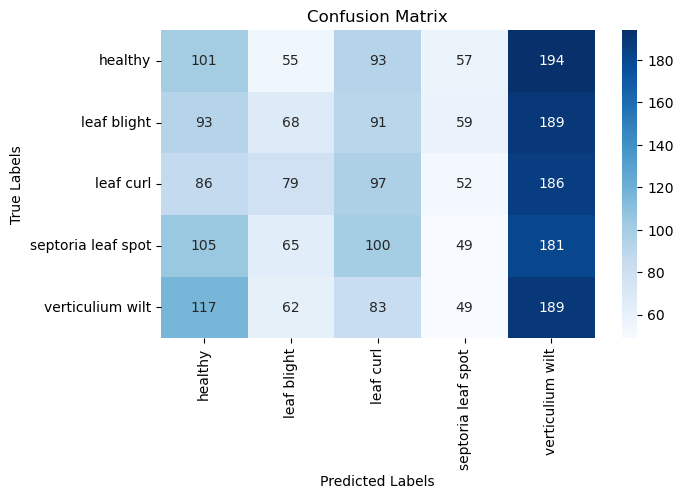

In [54]:

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(7, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

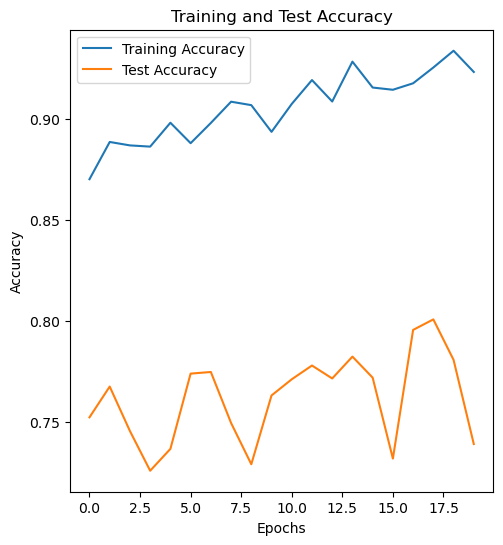

In [56]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(transfer_inception.history['accuracy'], label='Training Accuracy')
plt.plot(transfer_inception.history['val_accuracy'], label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()



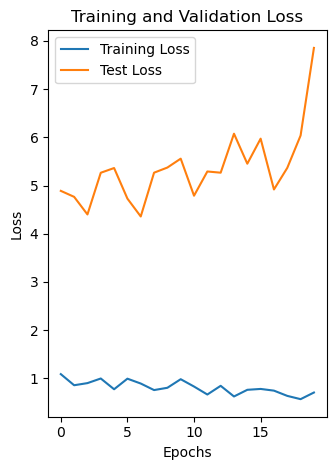

In [58]:
# Loss
plt.subplot(1, 2, 2)
plt.plot(transfer_inception.history['loss'], label='Training Loss')
plt.plot(transfer_inception.history['val_loss'], label='Test Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()